In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
%cd drive/MyDrive/pov-map

/content/drive/MyDrive/pov-map


In [4]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
from glob import glob
from batchers import dataset_constants, tfrecord_paths_utils
from models import processing
from models.loss import r2
from models.checkpoint import CustomModelCheckpoint
import datetime
import matplotlib.pyplot as plt

In [5]:
from google.colab import auth
auth.authenticate_user()

In [6]:
!echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt -qq update
!apt -qq install gcsfuse

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1210  100  1210    0     0  31025      0 --:--:-- --:--:-- --:--:-- 31025
OK
23 packages can be upgraded. Run 'apt list --upgradable' to see them.
The following NEW packages will be installed:
  gcsfuse
0 upgraded, 1 newly installed, 0 to remove and 23 not upgraded.
Need to get 13.8 MB of archives.
After this operation, 32.2 MB of additional disk space will be used.
Selecting previously unselected package gcsfuse.
(Reading database ... 128275 files and directories currently installed.)
Preparing to unpack .../gcsfuse_0.42.1_amd64.deb ...
Unpacking gcsfuse (0.42.1) ...
Setting up gcsfuse (0.42.1) ...


In [7]:
!gcsfuse --implicit-dirs dhs-raw-images data-gcs

2023/03/10 02:04:30.137332 Start gcsfuse/0.42.1 (Go version go1.19.5) for app "" using mount point: /content/drive/MyDrive/pov-map/data-gcs
2023/03/10 02:04:30.154332 Opening GCS connection...
2023/03/10 02:04:31.265606 Mounting file system "dhs-raw-images"...
2023/03/10 02:04:31.266797 File system has been successfully mounted.


In [8]:
combined_model = tf.keras.models.load_model(
    'models/saved_models/best_model_combined.h5', 
    custom_objects={'r2': r2}
)

### generate test data

In [124]:
# DHS_TFRECORDS_PATH_ROOT = 'data/dhs_tfrecords/' #local
DHS_TFRECORDS_PATH_ROOT = 'data-gcs/dhs_tfrecords/' #VM
CSV_PATH = 'data/dhs_clusters.csv' 
CHECKPOINT_PATH = 'models/checkpoints/' 

CLUSTERS_DF = pd.read_csv(CSV_PATH, float_precision='high', index_col=False)
MEANS = dataset_constants._MEANS_DHS
STDS = dataset_constants._STD_DEVS_DHS
BATCH_SIZE = 8
DATASET = 'DHS_OOC_A'
SHUFFLE = 16
PREFETCH = 2
EPOCHS = 100 # CHANGE
STEPS_PER_EPOCH = 1474
VALIDATION_STEPS = 488

In [125]:
def process_datasets_ir(dataset, shuffle, batch_size, prefetch, epochs):
    ''' prepares train_ds, val_ds and test_ds'''
    
    train_tfrecord_paths = tfrecord_paths_utils.dhs_ooc(dataset, split="train")
    val_tfrecord_paths = tfrecord_paths_utils.dhs_ooc(dataset, split="val")
    test_tfrecord_paths = tfrecord_paths_utils.dhs_ooc(dataset, split="test")
    
    # for testing - comment out
#     train_tfrecord_paths = train_tfrecord_paths[:300]
#     val_tfrecord_paths = val_tfrecord_paths[300:400]
#     test_tfrecord_paths = test_tfrecord_paths[0:1]
    print(len(train_tfrecord_paths), len(val_tfrecord_paths), len(test_tfrecord_paths))

    train_ds = tf.data.TFRecordDataset(train_tfrecord_paths, compression_type="GZIP")
    val_ds = tf.data.TFRecordDataset(val_tfrecord_paths, compression_type="GZIP")
    test_ds = tf.data.TFRecordDataset(test_tfrecord_paths, compression_type="GZIP")

    # normalize and resize
    train_ds = train_ds.map(processing.process_tfrecords)
    val_ds = val_ds.map(processing.process_tfrecords)  
    test_ds = test_ds.map(processing.process_tfrecords)

    # train_ds = train_ds.map(processing.augment)
    # val_ds = val_ds.map(processing.augment)  
    # test_ds = test_ds.map(processing.augment)

    train_ds = train_ds.cache()
#     train_ds = train_ds.shuffle(shuffle)
    train_ds = train_ds.batch(batch_size)
    train_ds = train_ds.repeat(epochs) # repeats the dataset for the number of epochs 
    train_ds = train_ds.prefetch(prefetch)

    val_ds = val_ds.cache()
#     val_ds = val_ds.shuffle(shuffle)
    val_ds = val_ds.batch(batch_size)
    val_ds = val_ds.prefetch(prefetch)

    test_ds = test_ds.cache()
#     test_ds = test_ds.shuffle(shuffle)
    test_ds = test_ds.batch(batch_size)
    test_ds = test_ds.prefetch(prefetch)

    return train_ds, val_ds, test_ds

In [126]:
ir_train_ds, ir_val_ds, ir_test_ds = process_datasets_ir(DATASET, SHUFFLE, BATCH_SIZE, PREFETCH, EPOCHS)

11797 3909 3963


In [127]:
def process_datasets_rgb(dataset, shuffle, batch_size, prefetch, epochs):
    ''' prepares train_ds, val_ds and test_ds'''
    
    train_tfrecord_paths = tfrecord_paths_utils.dhs_ooc(dataset, split="train")
    val_tfrecord_paths = tfrecord_paths_utils.dhs_ooc(dataset, split="val")
    test_tfrecord_paths = tfrecord_paths_utils.dhs_ooc(dataset, split="test")
    
    # for testing - comment out
#     train_tfrecord_paths = train_tfrecord_paths[:300]
#     val_tfrecord_paths = val_tfrecord_paths[300:400]
#     test_tfrecord_paths = test_tfrecord_paths[0:1]
    print(len(train_tfrecord_paths), len(val_tfrecord_paths), len(test_tfrecord_paths))

    train_ds = tf.data.TFRecordDataset(train_tfrecord_paths, compression_type="GZIP")
    val_ds = tf.data.TFRecordDataset(val_tfrecord_paths, compression_type="GZIP")
    test_ds = tf.data.TFRecordDataset(test_tfrecord_paths, compression_type="GZIP")

    # normalize and resize
    train_ds = train_ds.map(processing.process_tfrecords_rgb)
    val_ds = val_ds.map(processing.process_tfrecords_rgb)  
    test_ds = test_ds.map(processing.process_tfrecords_rgb)

    # train_ds = train_ds.map(processing.augment)
    # val_ds = val_ds.map(processing.augment)  
    # test_ds = test_ds.map(processing.augment)

    train_ds = train_ds.cache()
#     train_ds = train_ds.shuffle(shuffle)
    train_ds = train_ds.batch(batch_size)
    train_ds = train_ds.repeat(epochs) # repeats the dataset for the number of epochs 
    train_ds = train_ds.prefetch(prefetch)

    val_ds = val_ds.cache()
#     val_ds = val_ds.shuffle(shuffle)
    val_ds = val_ds.batch(batch_size)
    val_ds = val_ds.prefetch(prefetch)

    test_ds = test_ds.cache()
#     test_ds = test_ds.shuffle(shuffle)
    test_ds = test_ds.batch(batch_size)
    test_ds = test_ds.prefetch(prefetch)

    return train_ds, val_ds, test_ds

In [128]:
rgb_train_ds, rgb_val_ds, rgb_test_ds = process_datasets_rgb(DATASET, SHUFFLE, BATCH_SIZE, PREFETCH, EPOCHS)

11797 3909 3963


### eval

In [29]:
result = combined_model.evaluate(x=[rgb_test_2, ir_test_2], y=y_test, return_dict=True)

25/25 [==============================] - 14s 70ms/step - loss: 0.7059 - mse: 0.7059 - mae: 0.6661 - r2: 0.0801


### pred

In [15]:
!ls data-gcs/dhs_tfrecords/central_african_republic_2015/

00000.tfrecord.gz  00018.tfrecord.gz  00036.tfrecord.gz  00054.tfrecord.gz
00001.tfrecord.gz  00019.tfrecord.gz  00037.tfrecord.gz  00055.tfrecord.gz
00002.tfrecord.gz  00020.tfrecord.gz  00038.tfrecord.gz  00056.tfrecord.gz
00003.tfrecord.gz  00021.tfrecord.gz  00039.tfrecord.gz  00057.tfrecord.gz
00004.tfrecord.gz  00022.tfrecord.gz  00040.tfrecord.gz  00058.tfrecord.gz
00005.tfrecord.gz  00023.tfrecord.gz  00041.tfrecord.gz  00059.tfrecord.gz
00006.tfrecord.gz  00024.tfrecord.gz  00042.tfrecord.gz  00060.tfrecord.gz
00007.tfrecord.gz  00025.tfrecord.gz  00043.tfrecord.gz  00061.tfrecord.gz
00008.tfrecord.gz  00026.tfrecord.gz  00044.tfrecord.gz  00062.tfrecord.gz
00009.tfrecord.gz  00027.tfrecord.gz  00045.tfrecord.gz  00063.tfrecord.gz
00010.tfrecord.gz  00028.tfrecord.gz  00046.tfrecord.gz  00064.tfrecord.gz
00011.tfrecord.gz  00029.tfrecord.gz  00047.tfrecord.gz  00065.tfrecord.gz
00012.tfrecord.gz  00030.tfrecord.gz  00048.tfrecord.gz  00066.tfrecord.gz
00013.tfrecord.gz  00031.

In [9]:
car_files = os.listdir('data/central_african_republic_2021')

In [10]:
car_paths = []
for file in car_files:
    car_paths.append(os.path.join('data/central_african_republic_2021', file))

In [11]:
car_ds = tf.data.TFRecordDataset(car_paths, compression_type='GZIP')

In [17]:
def parse_red(ex):
    scalar_float_keys = ['lat', 'lon', 'year']
    img_bands = ['RED', 'GREEN', 'BLUE', 'NIR', 'SWIR1', 'SWIR2']

    keys_to_features = {}
    for band in img_bands:
        keys_to_features[band] = tf.io.FixedLenFeature(shape=[255**2], dtype=tf.float32)
    for key in scalar_float_keys:
        keys_to_features[key] = tf.io.FixedLenFeature(shape=[], dtype=tf.float32)
  
    ex = tf.io.parse_single_example(ex, features=keys_to_features)
    return ex['BLUE']

_ = car_ds.map(parse_red)

In [18]:
for i in _.as_numpy_iterator():
    _ = i
    break

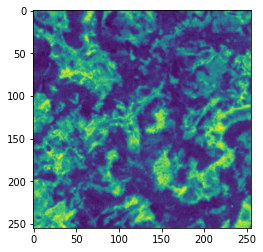

In [19]:
plt.imshow(_.reshape(255,255))

In [12]:
car_ds_rgb_proc = car_ds.map(processing.process_tfrecords_pred_rgb)
car_ds_ir_proc = car_ds.map(processing.process_tfrecords_pred_ir)

In [13]:
car_ds_rgb_proc

<MapDataset element_spec=TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None)>

In [20]:
i=0
for el in car_ds_rgb_proc.as_numpy_iterator():
    # if i<=50:
    #   i+=1
    #   continue
    _ = el
    i+=1
    break

In [21]:
_.shape

(224, 224, 3)

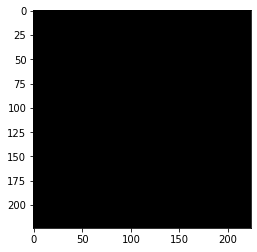

In [22]:
plt.imshow(_)

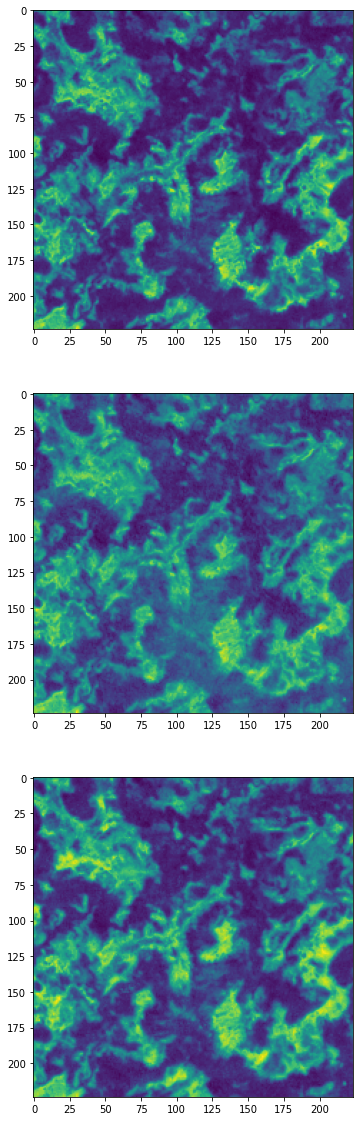

In [23]:
fig,axs = plt.subplots(3,1, figsize=(20,20))

for i in range(_.shape[2]):
    axs[i].imshow(_[:,:,i])

In [24]:
def preproc_combined_model(rgb_ds, ir_ds, label=False):
    rgb = []
    ir = []
    label = []
    if label:
        i=0
        for el in rgb_ds.as_numpy_iterator():
          rgb.append(el[0])
          label.append(el[1])
          if i // 5 == 0:
              print(i)
        i=0
        for el in ir_ds.as_numpy_iterator():
          ir.append(el[0])
          if i // 5 == 0:
              print(i)
        return rgb, ir, label
    else:
        i=0
        for el in rgb_ds.as_numpy_iterator():
            rgb.append(el)
            if i // 5 == 0:
                print(i)
        i=0
        for el in ir_ds.as_numpy_iterator():
            ir.append(el)
            if i // 5 == 0:
                print(i)
        return rgb, ir
        

In [25]:
rgb_data, ir_data = preproc_combined_model(car_ds_rgb_proc, car_ds_ir_proc)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [26]:
rgb_data = np.array(rgb_data)
ir_data = np.array(ir_data)

In [27]:
rgb_data.shape

(168, 224, 224, 3)

In [28]:
car_pred = combined_model.predict([rgb_data, ir_data])

6/6 [==============================] - 6s 494ms/step


In [38]:
car_pred

array([[-0.6511529 ],
       [-0.6812857 ],
       [-0.5891778 ],
       [-0.6677864 ],
       [-0.6878802 ],
       [-0.7154948 ],
       [-0.60661024],
       [-0.6797568 ],
       [-0.6429458 ],
       [-0.6297323 ],
       [-0.68248546],
       [-0.3708765 ],
       [-0.65698326],
       [-0.63340896],
       [-0.6142184 ],
       [-0.6471219 ],
       [-0.7001558 ],
       [-0.65197617],
       [-0.6848638 ],
       [-0.7024849 ],
       [-0.6408764 ],
       [-0.68205744],
       [-0.6627012 ],
       [-0.7100605 ],
       [-0.66027045],
       [-0.6163828 ],
       [-0.68076026],
       [-0.6438099 ],
       [-0.5453952 ],
       [-0.6303391 ],
       [-0.68016785],
       [-0.6774873 ],
       [-0.61834496],
       [-0.5992954 ],
       [-0.6621016 ],
       [-0.5026771 ],
       [-0.66828007],
       [-0.6286906 ],
       [-0.669185  ],
       [-0.6916588 ],
       [-0.60355455],
       [-0.6648233 ],
       [-0.6855999 ],
       [-0.6681575 ],
       [-0.72437114],
       [-0

In [49]:
# car_df1 = pd.read_csv('data/car72.csv')
# car_df1['dataset'] = 1
car_df2 = pd.read_csv('data/car_clusters_2.csv')
# car_df2['dataset'] = 2

In [50]:
# pd.concat((car_df1, car_df2), axis=0).sort_values('lon')

In [54]:
car_df2['wealthpooled'] = car_pred
car_df2 = car_df2.drop(columns=['Unnamed: 0'])
car_df2

,lon,lat,country,year,wealthpooled
0,18.495498,4.389060,central_african_republic,2021,-0.651153
1,18.757613,4.933273,central_african_republic,2021,-0.681286
2,18.204969,5.519118,central_african_republic,2021,-0.589178
3,18.019156,4.748874,central_african_republic,2021,-0.667786
4,17.667379,5.323275,central_african_republic,2021,-0.687880
...,...,...,...,...,...
163,25.999897,5.310481,central_african_republic,2021,-0.510654
164,27.000953,5.313046,central_african_republic,2021,-0.629250
165,25.218374,5.314325,central_african_republic,2021,-0.645586
166,25.614828,5.971676,central_african_republic,2021,-0.649348


In [55]:
car_df2.to_csv('data/car_with_pred_new.csv', index=False)

### create data to feed to the combined model

In [129]:
rgb_train = []
rgb_y_train = []
rgb_test = []
rgb_y_test = []

# i=0
# for el in rgb_train_ds.as_numpy_iterator():
#     rgb_train.append(el[0])
#     rgb_y_train.append(el[1])
#     print(i)
#     i+=1

i=0
for el in rgb_test_ds.as_numpy_iterator():
    rgb_test.append(el[0])
    rgb_y_test.append(el[1])
    if i // 5 == 0:
        print(i)
    i+=1

# np.save('data-gcs/train_rgb_all', rgb_train_2)
# np.save('data-gcs/test_rgb_all', rgb_test_2)
# rgb_train_816_tensor = tf.convert_to_tensor(rgb_train_2) 


0
1
2
3
4


In [ ]:
rgb_test_2 = np.array(rgb_test) #.reshape(496, 224, 224, 3)
rgb_test_3 = []
for i in rgb_test_2:
    for x in i:
        rgb_test_3.append(np.array(x))
# np.save('data-gcs/test_rgb_all', rgb_test_2)
# rgb_test_2.shape

<ipython-input-143-1245197ed839>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  rgb_test_2 = np.array(rgb_test) #.reshape(496, 224, 224, 3)


In [142]:
rgb_test_3.shape

(8, 224, 224, 3)

In [22]:
# y_train = np.array(rgb_y_train).reshape(11797)
y_test = np.array(rgb_y_test).reshape(792)
# np.save('data-gcs/train_y_all', y_train)
np.save('data-gcs/test_y_all', y_test)
# y_tensor = tf.convert_to_tensor(y)

In [24]:
ir_train = []
ir_y_train = []
ir_test = []
ir_y_test = []

# i=0
# for el in ir_train_ds.as_numpy_iterator():
#     ir_train.append(el[0])
#     ir_y_train.append(el[1])
#     print(i)
#     i+=1

i=0
for el in ir_test_ds.as_numpy_iterator():
    ir_test.append(el[0])
    ir_y_test.append(el[1])
    if i // 5 == 0:
        print(i)
    i+=1
    
# ir_train_2 = np.array(ir_train).reshape(11797, 224, 224, 3)
ir_test_2 = np.array(ir_test).reshape(792, 224, 224, 3)
# ir_train_all_tensor = tf.convert_to_tensor(ir_train_2)
# np.save('data-gcs/train_ir_all', ir_train_2)
np.save('data-gcs/test_ir_all', ir_test_2)